In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
"""
Gera uma reta aleatória
"""
def generate_line():
    
    # Dimensões do poblema
    d = 2
    
    # Gera 2 pontos aleatórios entre 0 e 1 e os converte para
    # o intervalo entre -1 e 1
    p1 = np.random.rand(d) * 2 - 1
    p2 = np.random.rand(d) * 2 - 1
    
    # Calcula a reta na forma `y=ax + b` entre os pontos
    a = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - a*p1[0]

    return np.array([b, a, -1])

"""
Gera os dados baseados em uma reta
"""
def generate_data(line, n):
    
    # Gera 'n' pontos (x, y) aleatoriamente entre 0 e 1
    # e os converte para o intervalo -1 e 1
    points = (np.random.rand(n, 2) * 2) - 1
    
    return points

"""
Calcula os valores de saída da função ideal
"""
def calc_y(line, data):
    y = line[0] + np.dot(data, line[1:])
    
    # Transforma os valores em -1 ou 1
    # Valores em cima da reta são considerados -1
    y = np.where(y > 0, 1, -1)
    
    return y

In [3]:
"""
Executa o perceptron para um conjunto de dados e de pesos iniciais
Caso os pesos não sejam especificados, eles serão o vetor nulo
"""
def perceptron(data, y, weights=None):
    if weights is None:
        # Cria um vetor de zeros do tamanho da quantidade de dimensões + viés
        weights = np.zeros(data.shape[1]+1 if len(data.shape) > 1 else 1)

    # Contador de iterações
    it = 0

    # Adiciona a coluna do viés ao X
    m_data = np.concatenate((np.ones((data.shape[0], 1)), data), axis=1)
    
    # Vetor que indica quais pontos estão classificados erroneamente
    # Inicialmente começa com 1(True) para todos os valores,
    # pois nenhum dado foi classificado
    miscl_mask = np.ones(m_data.shape[0], dtype=bool)
    
    # Filtra os dados para que não foram classificados
    miscl_data = m_data[miscl_mask]
    
    # Executar até que não haja mais pontos classificados erroneamente
    while miscl_data.shape[0] > 0:
        
        # Filtra os dados de saída não classificados
        miscl_y = y[miscl_mask]

        # Seleciona um ponto aleatório dentro o conjunto dos não classificados
        i = np.random.randint(miscl_data.shape[0])

        # Atualiza os pesos
        weights += miscl_y[i] * miscl_data[i]

        # Calcula as saídas com os novos pesos
        temp = np.sign(np.dot(m_data, weights))
        
        # Atualiza os pontos não classificados
        # Caso os valores calculados sejam diferentes dos corretos
        # a subtração vai dar um valor diferente de 0
        # que quando convertido para um tipo 'bool' valerá 'True'
        # ou seja, classificado erroneamente
        miscl_mask = np.array( temp - y, dtype=bool)
        
        # Atualiza os dados classificados erroneamente
        miscl_data = m_data[miscl_mask]
        
        # Atualiza a iteração do algoritmo
        it += 1
        
    # Retorna os pesos finais e o número de iterações
    return weights, it

In [4]:
"""
Exibe o gráfico de um experimento
"""
def plot_experiment(data, y, line, w_line):
    
    # Cores dos pontos, dependendo de em qual lado da reta eles estão
    colormap = [ 'r' if y_n > 0 else 'g' for y_n in y ]
    
    # Limites para o gráfico
    plt.ylim([-1, 1])
    plt.xlim([-1, 1])
    
    # Funções f(x) e g(x)
    f = lambda x: -(line[0]/line[2] + (line[1]/line[2]) * x)
    g = lambda x: -(w_line[0]/w_line[2] + (w_line[1]/w_line[2]) * x)
    
    bounds = np.array([-1, 1])
    
    f_y = f(bounds)
    g_y = g(bounds)
    
    # Gera a linha para as funções
    plt.plot(bounds, f_y, label='f(x)')
    plt.plot(bounds, g_y, label='g(x)')
    
    # Exibe a legenda do lado de fora do gráfico
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    # Gera os pontos
    plt.scatter(data[:, 0], data[:, 1], c=colormap)
    
    # Exibe o gráfico
    plt.show()

In [5]:
"""
Executa um experimento de acordo com a quantidade de dados a serem gerados
"""
def experiment(N, plot=False):
    
    # Gera os dados e roda o perceptron
    line = generate_line()
    data = generate_data(line, N)
    y = calc_y(line, data)
    
    w, it = perceptron(data, y)

    if plot:
        plot_experiment(data, y, line, w)
        
    else:
        error = calc_error(line, w)
        
        # Retorna o número de iterações e o erro fora da amostra
        return [it, error]
    
def calc_error(line, w):
    
    # Gera mil pontos para serem avaliados
    ev_data = generate_data(line, 1000)
    
    # Saída ideal
    ev_f_y = calc_y(line, ev_data)
    
    # Saída gerada pela g(x)
    ev_g_y = calc_y(w, ev_data)
    
    # Conta todos os pontos em que as saídas não foram iguais
    misclassified = np.count_nonzero(ev_f_y - ev_g_y)

    # Calcula a porcentagem dos pontos classificados erroneamente
    return misclassified / ev_data.shape[0]

In [6]:
"""
Executa um certo número de experimentos paralelamente
Caso o número de processos não seja espeficidado,
o multiprocessing utiliza o valor padrão,
que costuma ser o número de processadores
"""
def run_experiment(N, num_exp, processes=None):
    pool = mp.Pool(processes)
    
    # Executa os experimentos 'num_exp' vezes, passando como
    # parâmetro para cada um, o número de dados N a serem gerados
    results = np.array(pool.map(experiment, [N] * num_exp))
    
    pool.close()
    
    # Calcula a média dos resuldados por coluna (iterações, erro)
    return np.mean(results, axis=0)

In [15]:
test_1, test_2 = run_experiment(10, 1000)
test_3, test_4 = run_experiment(100, 1000)

print('Teste 1:', test_1)
print('Teste 2:', test_2)

print('Teste 3:', test_3)
print('Teste 4:', test_4)

Teste 1: 8.141
Teste 2: 0.112643
Teste 3: 97.377
Teste 4: 0.0142


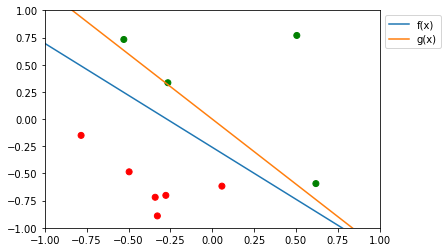

In [13]:
experiment(10, plot=True)

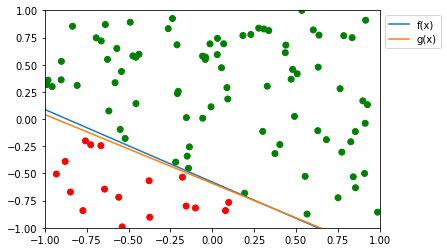

In [14]:
experiment(100, plot=True)